In [ ]:
############################################################################### Section 1 ###############################################################################

In [1]:
###############################################################################
# Purpose: 
#   1) Load & preprocess training data (Cortical_DataSet.h5ad).
#   2) Build and train an ensemble of models.
#   3) Save the trained models and training variables for later analysis.
###############################################################################

import os
import pickle
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import shap
import umap 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GaussianNoise
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from gprofiler import GProfiler

In [2]:
###############################################################################
# Check TF version and GPU memory growth
###############################################################################
print("TensorFlow version:", tf.__version__)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for GPUs.")
    except RuntimeError as e:
        print("Error setting in memory growth:", e)

TensorFlow version: 2.10.0
Memory growth enabled for GPUs.


In [3]:
###############################################################################
# 1) Load & Preprocess the Training Data
###############################################################################
#Load the training data
adata = sc.read_h5ad(r"C:/Users/germa/Desktop/DNN-Project/Cortical_DataSet.h5ad")
print("Training data metadata (first 5 rows):")
print(adata.obs.head())

if adata.raw is not None:
    adata_raw = adata.raw.to_adata()
else:
    adata_raw = adata.copy()

# Preprocess the training data
sc.pp.normalize_total(adata_raw, target_sum=1e4)
sc.pp.log1p(adata_raw)
sc.pp.highly_variable_genes(adata_raw, n_top_genes=3000, subset=True, flavor='seurat')
sc.pp.scale(adata_raw)

# Extract the Preprocess training data
train_genes = adata_raw.var_names
print("Training gene set length:", len(train_genes))

X_processed = adata_raw.X.toarray() if hasattr(adata_raw.X, "toarray") else adata_raw.X
y_labels = adata.obs['cell_type'].values
print("X_processed shape:", X_processed.shape)
print("y_labels shape:", y_labels.shape)

# Map Ensembl IDs -> gene symbols (for later SHAP analysis)
gp = GProfiler(return_dataframe=True)
ensembl_ids = list(adata.var_names)
mapping_df = gp.convert(organism='hsapiens', query=ensembl_ids)
mapping_dict = dict(zip(mapping_df['incoming'], mapping_df['name']))
gene_names_actual = np.array([mapping_dict.get(gene, gene) for gene in adata.var_names])
print("10 gene name mapping:", gene_names_actual[:10])

Training data metadata (first 5 rows):
                                           Class CrossArea_subclass  \
AAAGGATAGACATATG-5L8TX_200107_01_G09  inhibitory              Lamp5   
AACAACCGTTCTCCTG-5L8TX_200107_01_G09  inhibitory              Lamp5   
AACAAGATCTCTTCAA-5L8TX_200107_01_G09  inhibitory              Lamp5   
AACCATGTCCAGCAAT-5L8TX_200107_01_G09  inhibitory              Lamp5   
AACCCAAGTACCCGCA-5L8TX_200107_01_G09  inhibitory              Lamp5   

                                     CrossArea_cluster WithinArea_subclass  \
AAAGGATAGACATATG-5L8TX_200107_01_G09           Lamp5_2               Lamp5   
AACAACCGTTCTCCTG-5L8TX_200107_01_G09           Lamp5_4               Lamp5   
AACAAGATCTCTTCAA-5L8TX_200107_01_G09           Lamp5_2               Lamp5   
AACCATGTCCAGCAAT-5L8TX_200107_01_G09           Lamp5_4               Lamp5   
AACCCAAGTACCCGCA-5L8TX_200107_01_G09           Lamp5_4               Lamp5   

                                     WithinArea_cluster          

In [4]:
###############################################################################
# 2) Train/Test Split & Label Conversion
###############################################################################

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_labels, test_size=0.3, random_state=42, stratify=y_labels
)

if isinstance(y_train[0], str):
    unique_labels = np.unique(y_train)
    label_mapping = {lbl: i for i, lbl in enumerate(unique_labels)}
    inv_label_mapping = {v: k for k, v in label_mapping.items()}
    y_train = np.array([label_mapping[lbl] for lbl in y_train])
    y_test  = np.array([label_mapping[lbl] for lbl in y_test])
else:
    label_mapping = None
    inv_label_mapping = None

# Save the label mapping
num_classes = len(np.unique(y_train))
print("Number of classes:", num_classes)

cw = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(cw))
print("Computed class weights:", class_weights)

Number of classes: 18
Computed class weights: {0: 0.112044616175482, 1: 7.82879415827906, 2: 2.9325423227618836, 3: 0.7886224925945806, 4: 1.6638773541378298, 5: 7.470527306967985, 6: 41.581236897274636, 7: 5.253410144351742, 8: 2.647213880547214, 9: 1.1967448034512926, 10: 4.043679918450561, 11: 3.4273803352341456, 12: 1.1666519616493147, 13: 2.4459551116043903, 14: 0.7176182206302688, 15: 2.8417866609355973, 16: 0.6219290406534657, 17: 57.994883040935676}


In [5]:
###############################################################################
# 3) Define Model & Callbacks
###############################################################################
# Define the model specifically for rnaSEQ data and decrease overfitting
class LearningRateTracker(Callback):
    """Track of learning rate at the end of each epoch."""
    def __init__(self):
        super().__init__()
        self.lrs = []
    def on_epoch_end(self, epoch, logs=None):
        lr_obj = self.model.optimizer.learning_rate
        if hasattr(lr_obj, '__call__'):
            current_lr = lr_obj(self.model.optimizer.iterations)
            lr_value = tf.keras.backend.get_value(current_lr)
        else:
            lr_value = tf.keras.backend.get_value(lr_obj)
        self.lrs.append(lr_value)

def build_model(input_shape, num_classes, l2_reg=1e-3):
    """Build a simple feedforward NN with GaussianNoise, L2, Dropout, BN."""
    reg = tf.keras.regularizers.l2(l2_reg)
    model = Sequential([
        GaussianNoise(0.1, input_shape=(input_shape,)),
        Dense(256, activation='relu', kernel_regularizer=reg),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu', kernel_regularizer=reg),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu', kernel_regularizer=reg),
        BatchNormalization(),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [6]:
###############################################################################
# 4) Train an Ensemble of Models
###############################################################################
# Train an ensemble of models with early stopping, LR reduction, and model checkpointing for better generalization of learning and performance of predictions in other datasets
n_models = 5
ensemble_models = []
histories = []     # to store training histories of each model
lr_data_list = []  # to store LR data for each model

for i in range(n_models):
    print(f"Training model {i+1}/{n_models}...")
    tf.keras.backend.clear_session()

    lr_tracker = LearningRateTracker()
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1),
        ModelCheckpoint(f'best_model_{i}.h5', monitor='val_loss', save_best_only=True, verbose=1),
        lr_tracker
    ]

    model_i = build_model(X_train.shape[1], num_classes, l2_reg=1e-3)
    history_i = model_i.fit(
        X_train, y_train,
        epochs=100,
        batch_size=64,
        validation_split=0.2,
        callbacks=callbacks,
        verbose=1,
        class_weight=class_weights
    )

    ensemble_models.append(model_i)
    model_i.save(f'my_trained_model_{i}.h5')
    
    histories.append(history_i.history)
    lr_data_list.append(lr_tracker.lrs)

print("Ensemble training complete.")

# Save final model’s history :
final_history = histories[-1]

Training model 1/5...
Epoch 1/100
991/992 [============================>.] - ETA: 0s - loss: 1.2778 - accuracy: 0.8556
Epoch 1: val_loss improved from inf to 0.70756, saving model to best_model_0.h5
992/992 [==============================] - 5s 4ms/step - loss: 1.2774 - accuracy: 0.8557 - val_loss: 0.7076 - val_accuracy: 0.9931 - lr: 0.0010
Epoch 2/100
983/992 [============================>.] - ETA: 0s - loss: 0.6866 - accuracy: 0.9824
Epoch 2: val_loss improved from 0.70756 to 0.54678, saving model to best_model_0.h5
992/992 [==============================] - 4s 4ms/step - loss: 0.6859 - accuracy: 0.9823 - val_loss: 0.5468 - val_accuracy: 0.9934 - lr: 0.0010
Epoch 3/100
981/992 [============================>.] - ETA: 0s - loss: 0.5688 - accuracy: 0.9849
Epoch 3: val_loss improved from 0.54678 to 0.47033, saving model to best_model_0.h5
992/992 [==============================] - 4s 4ms/step - loss: 0.5684 - accuracy: 0.9849 - val_loss: 0.4703 - val_accuracy: 0.9931 - lr: 0.0010
Epoch 4

In [7]:
###############################################################################
# 5) Save All Training Variables
###############################################################################
train_vars = {
    'train_genes': train_genes,
    'label_mapping': label_mapping,
    'inv_label_mapping': inv_label_mapping,
    'X_processed': X_processed,
    'y_labels': y_labels
}

project_path = r"C:/Users/germa/Desktop/DNN-Project"
train_vars_path = os.path.join(project_path, "train_variables.pkl")

with open(train_vars_path, 'wb') as f:
    pickle.dump(train_vars, f)

# Save the final model’s history
with open('training_history.pkl', 'wb') as f:
    pickle.dump(final_history, f)

# Save *all* ensemble histories
with open('training_histories.pkl', 'wb') as f:
    pickle.dump(histories, f)

# Save the final model’s LR data
with open('lr_data.pkl', 'wb') as f:
    pickle.dump(lr_data_list[-1], f)

print("All training variables, ensemble histories, and LR data have been saved.")
print("Done. Now it is possible to RESET the kernel for memory saving reasons if needed.")

All training variables, ensemble histories, and LR data have been saved.
Done. You can now RESET the kernel for memory reasons if needed.


In [ ]:
############################################################################### Section 2 ###############################################################################

In [3]:
#################################################################################################################################################################
# Purpose:
#   1) Reload the saved training variables and ensemble models.
#   2) Evaluate on the test set (confusion matrix, classification report, etc.).
#   3) Plot training history curves (loss, accuracy, LR).
#   4) Cross-validation code, SHAP analysis, calibration, ROC/PR, UMAP, t-SNE, etc.
###############################################################################################################################################################
# Import necessary libraries again after reseting kernel
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import anndata as ad
import umap
import shap
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve, auc, precision_recall_curve
)
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.manifold import TSNE
import pandas as pd


In [4]:
###############################################################################
# 1) Load Train Variables & Models
###############################################################################

# Load the training variables from section 1

project_path = r"C:/Users/germa/Desktop/DNN-Project"
train_vars_path = os.path.join(project_path, "train_variables.pkl")

if not os.path.exists(train_vars_path):
    raise SystemExit(f"Error: No file found at {train_vars_path}.")

with open(train_vars_path, 'rb') as f:
    train_vars = pickle.load(f)

# Extract items
X_processed       = train_vars['X_processed']
y_labels          = train_vars['y_labels']
train_genes       = train_vars['train_genes']
label_mapping     = train_vars['label_mapping']
inv_label_mapping = train_vars['inv_label_mapping']

# Re-create the train split used in training
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_labels, test_size=0.3, random_state=42, stratify=y_labels
)

# Convert to numerical labels
if isinstance(y_train[0], str) and label_mapping is not None:
    y_train = np.array([label_mapping[lbl] for lbl in y_train])
    y_test  = np.array([label_mapping[lbl] for lbl in y_test])

num_classes = len(np.unique(y_train))
class_names = [inv_label_mapping[i] for i in range(num_classes)]
print("Number of classes:", num_classes)
print("class_names:", class_names)

# Load ensemble trained models 
n_models = 5
ensemble_models = []
for i in range(n_models):
    model_path = f'my_trained_model_{i}.h5'
    if not os.path.exists(model_path):
        raise SystemExit(f"Error: Model file '{model_path}' not found.")
    ensemble_models.append(load_model(model_path))

print(f"\nLoaded {len(ensemble_models)} ensemble models.")

Number of classes: 18
class_names: ['L2/3-6 intratelencephalic projecting glutamatergic neuron', 'L5 extratelencephalic projecting glutamatergic cortical neuron', 'L6b glutamatergic cortical neuron', 'VIP GABAergic cortical interneuron', 'astrocyte of the cerebral cortex', 'caudal ganglionic eminence derived interneuron', 'cerebral cortex endothelial cell', 'chandelier pvalb GABAergic cortical interneuron', 'corticothalamic-projecting glutamatergic cortical neuron', 'lamp5 GABAergic cortical interneuron', 'microglial cell', 'near-projecting glutamatergic cortical neuron', 'oligodendrocyte', 'oligodendrocyte precursor cell', 'pvalb GABAergic cortical interneuron', 'sncg GABAergic cortical interneuron', 'sst GABAergic cortical interneuron', 'vascular leptomeningeal cell']

Loaded 5 ensemble models.


1063/1063 [==============================] - 1s 827us/step

Ensemble Test Accuracy: 99.61%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16859
           1       0.99      1.00      1.00       242
           2       1.00      1.00      1.00       644
           3       0.99      1.00      1.00      2395
           4       1.00      1.00      1.00      1135
           5       0.95      0.97      0.96       253
           6       1.00      1.00      1.00        46
           7       1.00      1.00      1.00       359
           8       1.00      1.00      1.00       714
           9       0.99      0.99      0.99      1579
          10       1.00      1.00      1.00       467
          11       1.00      1.00      1.00       552
          12       1.00      1.00      1.00      1619
          13       1.00      1.00      1.00       772
          14       0.99      0.99      0.99      2632
          15       0

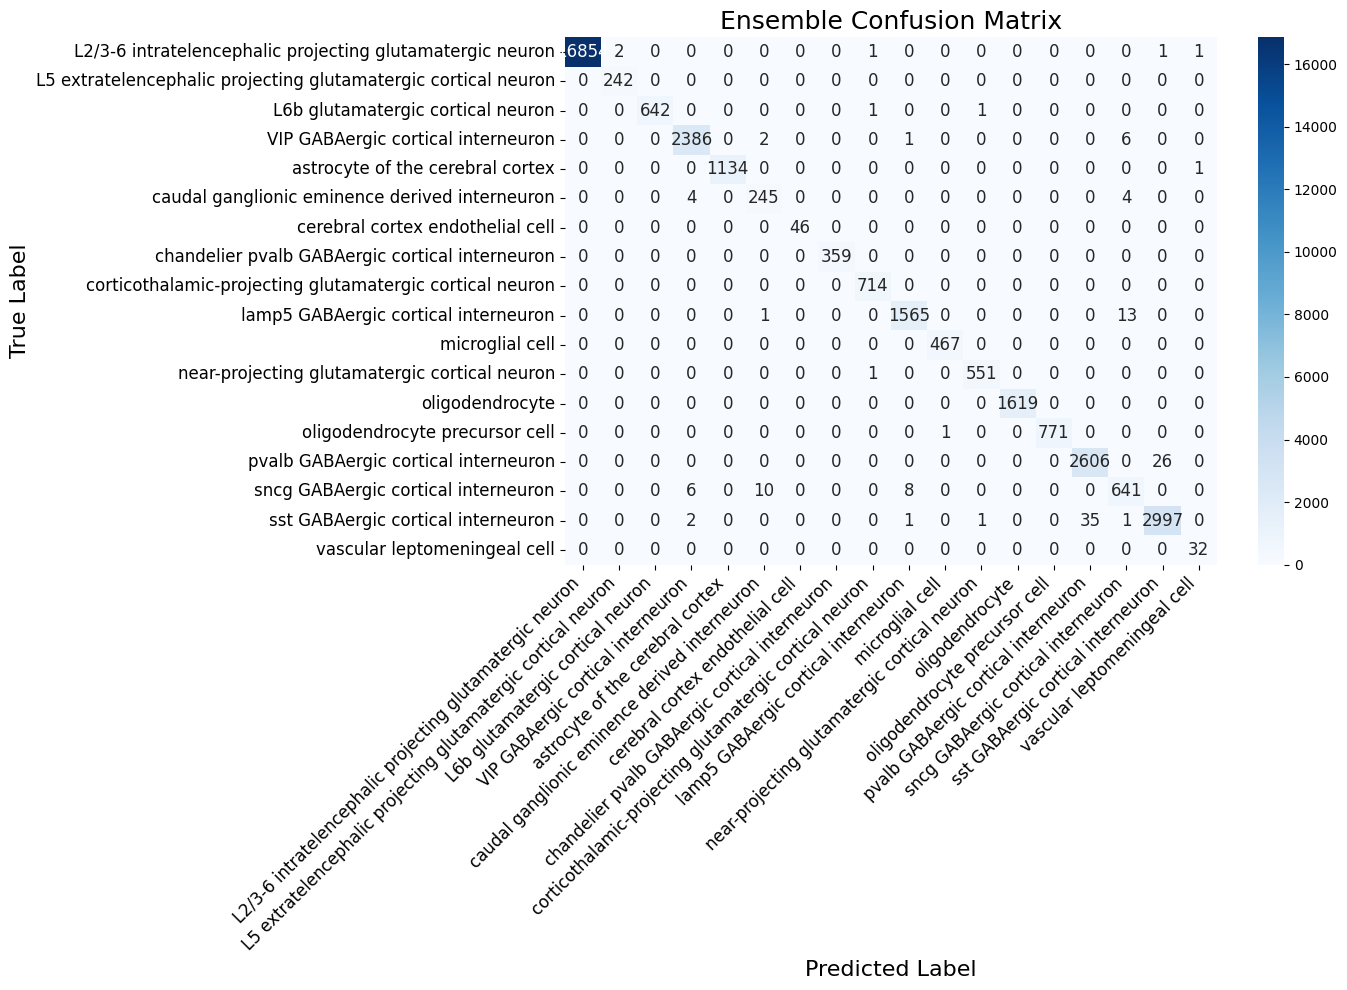

In [5]:
###############################################################################
# 2) Evaluate on the Test Set (Confusion Matrix, Classification)
###############################################################################

# Evaluate the ensemble on the test set
all_preds = [m.predict(X_test) for m in ensemble_models]
ensemble_prob = np.mean(all_preds, axis=0)
y_pred_ensemble = np.argmax(ensemble_prob, axis=1)

accuracy = np.mean(y_pred_ensemble == y_test)
print("\nEnsemble Test Accuracy: {:.2f}%".format(accuracy * 100))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_ensemble))

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred_ensemble)
plt.figure(figsize=(14, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names,
    annot_kws={"size": 12}
)
plt.title('Ensemble Confusion Matrix', fontsize=18)
plt.xlabel('Predicted Label', fontsize=16)
plt.ylabel('True Label', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.show()

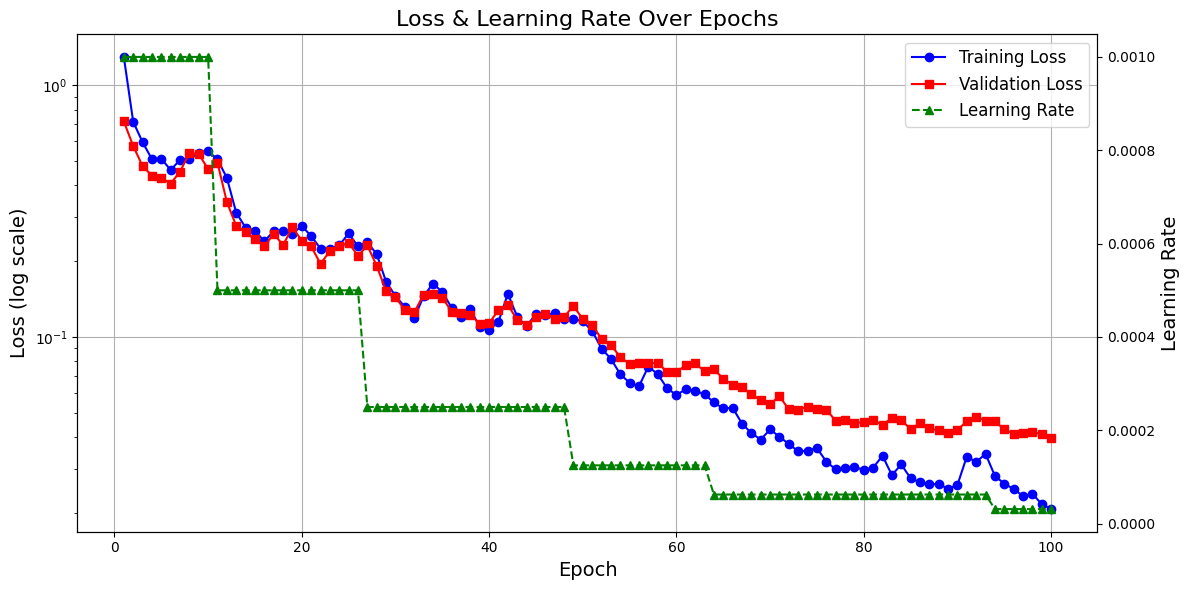

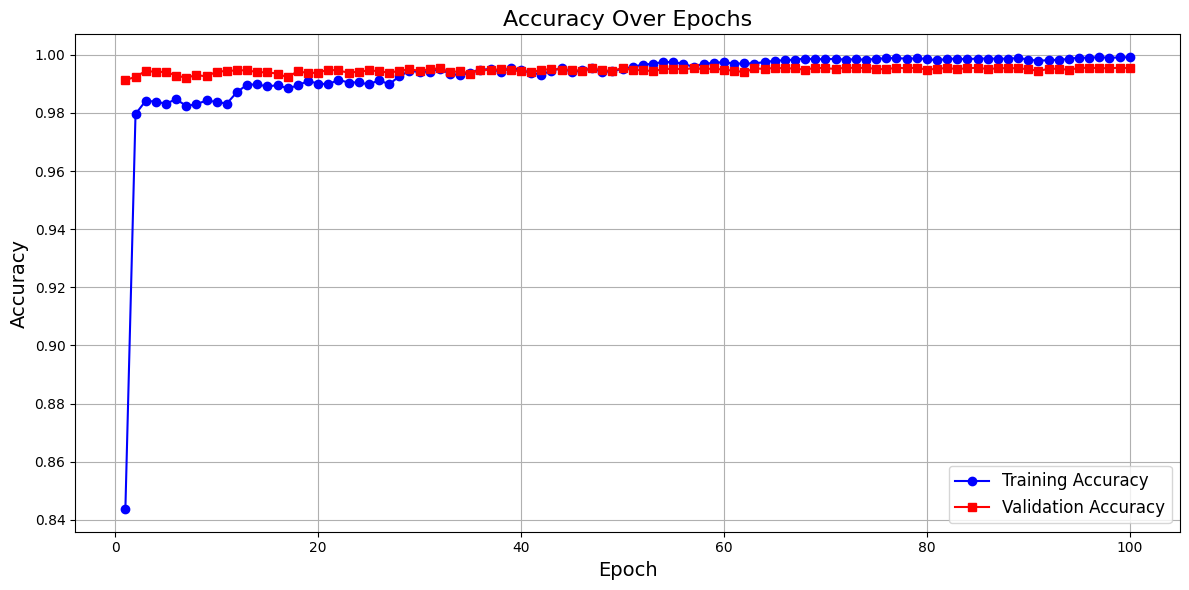

In [6]:
###############################################################################
# 3) Plot Training History (Loss-Accuracy curves)
###############################################################################
if os.path.exists('training_history.pkl'):
    with open('training_history.pkl', 'rb') as f:
        single_history = pickle.load(f)
    if 'loss' in single_history and 'val_loss' in single_history:
        epochs_range = range(1, len(single_history['loss']) + 1)

        ## Plot Loss
        if os.path.exists('lr_data.pkl'):
            with open('lr_data.pkl', 'rb') as f:
                lr_data = pickle.load(f)
        else:
            lr_data = None

        fig, ax1 = plt.subplots(figsize=(12, 6))
        ax1.plot(epochs_range, single_history['loss'], 'b-o', label='Training Loss')
        ax1.plot(epochs_range, single_history['val_loss'], 'r-s', label='Validation Loss')
        ax1.set_yscale('log')
        ax1.set_xlabel('Epoch', fontsize=14)
        ax1.set_ylabel('Loss (log scale)', fontsize=14)
        ax1.grid(True)

        # ADD LR data on secondary axis
        if lr_data is not None:
            ax2 = ax1.twinx()
            ax2.plot(epochs_range, lr_data, 'g--^', label='Learning Rate')
            ax2.set_ylabel('Learning Rate', fontsize=14)

            h1, l1 = ax1.get_legend_handles_labels()
            h2, l2 = ax2.get_legend_handles_labels()
            ax1.legend(h1 + h2, l1 + l2, loc='upper right', fontsize=12)
        else:
            ax1.legend(loc='upper right', fontsize=12)

        plt.title('Loss & Learning Rate Over Epochs', fontsize=16)
        plt.tight_layout()
        plt.show()

        # Plot Accuracy
        plt.figure(figsize=(12, 6))
        plt.plot(epochs_range, single_history['accuracy'], 'b-o', label='Training Accuracy')
        plt.plot(epochs_range, single_history['val_accuracy'], 'r-s', label='Validation Accuracy')
        plt.xlabel('Epoch', fontsize=14)
        plt.ylabel('Accuracy', fontsize=14)
        plt.title('Accuracy Over Epochs', fontsize=16)
        plt.legend(fontsize=12)
        plt.grid(True)
        plt.tight_layout()
        plt.show()
else:
    print("'training_history.pkl' was not found")

In [7]:
%matplotlib widget

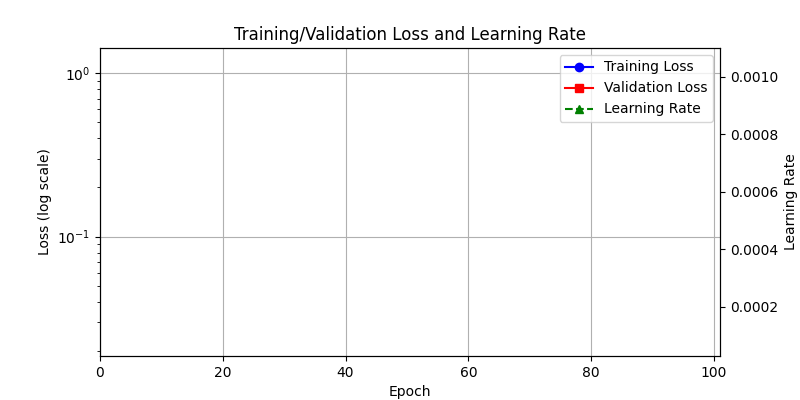

In [8]:
# ------------------------------------------------------------------------------
# ADD-ON 1: Animated Plot of Training/Validation Loss & Learning Rate
# ------------------------------------------------------------------------------

import matplotlib.animation as animation

# 1) Load the saved training history and LR data.
with open('training_history.pkl', 'rb') as f:
    training_history = pickle.load(f)
with open('lr_data.pkl', 'rb') as f:
    lr_data = pickle.load(f)

# 2) Extract arrays for plotting
loss_data = training_history['loss']
val_loss_data = training_history['val_loss']
num_epochs = len(loss_data)

# 3) Set up the figure and axes
fig, ax1 = plt.subplots(figsize=(8, 4))
ax1.set_xlim(0, num_epochs + 1)

# Combine all loss to set y-limits
all_loss = loss_data + val_loss_data
ax1.set_ylim(min(all_loss) * 0.9, max(all_loss) * 1.1)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (log scale)')
ax1.set_yscale('log')
ax1.set_title('Training/Validation Loss and Learning Rate')
ax1.grid(True)

# 4) Plot placeholders for training/val loss lines
line_train, = ax1.plot([], [], 'b-o', label='Training Loss')
line_val, = ax1.plot([], [], 'r-s', label='Validation Loss')

# Create a secondary axis for learning rate
ax2 = ax1.twinx()
ax2.set_ylim(min(lr_data) * 0.9, max(lr_data) * 1.1)
ax2.set_ylabel('Learning Rate')
line_lr, = ax2.plot([], [], 'g--^', label='Learning Rate')

# Combine legends
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper right', fontsize=10)

# 5) Define init and animate functions for FuncAnimation
def init():
    line_train.set_data([], [])
    line_val.set_data([], [])
    line_lr.set_data([], [])
    return line_train, line_val, line_lr

def animate(i):
    # i is the current frame (epoch)
    x = list(range(1, i + 1))
    line_train.set_data(x, loss_data[:i])
    line_val.set_data(x, val_loss_data[:i])
    line_lr.set_data(x, lr_data[:i])
    return line_train, line_val, line_lr

# 6) Create the animation
ani = animation.FuncAnimation(
    fig, animate, 
    frames=num_epochs + 1,
    init_func=init, 
    interval=500, 
    blit=True
)

plt.show()

# save to a GIF file
ani.save('loss_lr_animation.gif', writer='pillow', fps=2)


In [9]:
 %matplotlib inline 

Missing 'X_processed'/'y_labels'. Load training model or reprocess dataset.
Numeric labels for cross-validation. #Classes: 18
Number of classes: 18
Starting k-fold cross-validation...

Fold 1/5
Restoring model weights from the end of the best epoch: 21.
Epoch 31: early stopping

Fold 2/5
Restoring model weights from the end of the best epoch: 12.
Epoch 22: early stopping

Fold 3/5
Restoring model weights from the end of the best epoch: 7.
Epoch 17: early stopping

Fold 4/5
Restoring model weights from the end of the best epoch: 11.
Epoch 21: early stopping

Fold 5/5
Restoring model weights from the end of the best epoch: 10.
Epoch 20: early stopping


C:\Users\germa\AppData\Local\Temp\ipykernel_26364\478803373.py:112: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([fold_train_acc, fold_val_acc],


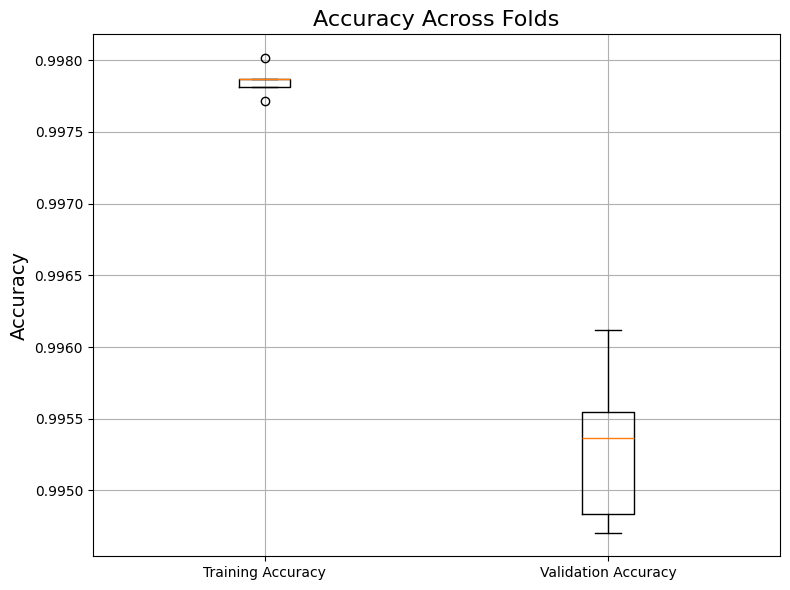

C:\Users\germa\AppData\Local\Temp\ipykernel_26364\478803373.py:121: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([fold_train_loss, fold_val_loss],


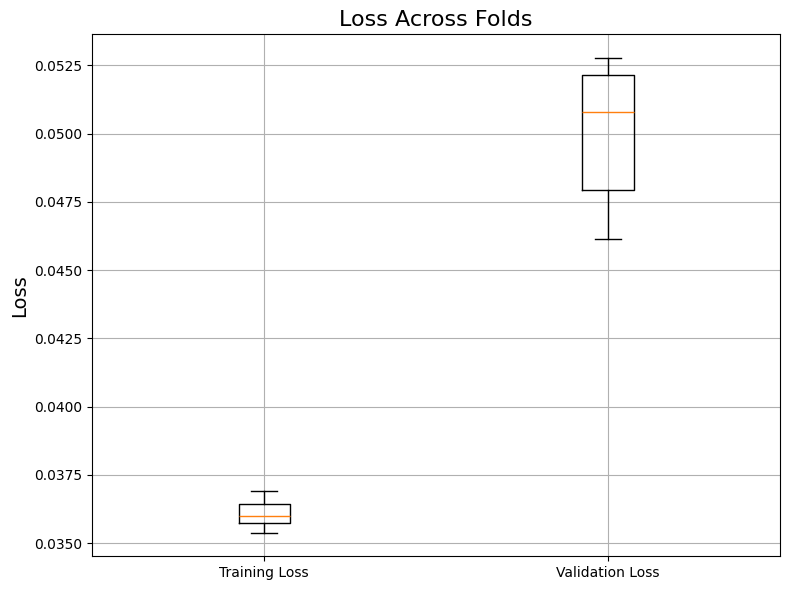

Generalization Gap for each fold: [0.00175351 0.00232702 0.00311005 0.00264686 0.00287873]


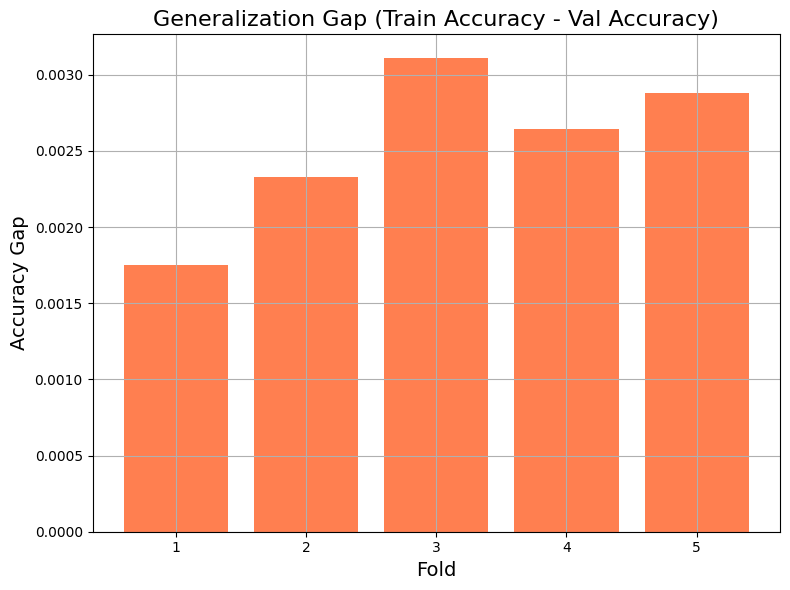

cross-validation analysis finished.


In [13]:
# ------------------------------------------------------------------------------
# ADD-ON 2: Cross-Validation (StratifiedKFold) Within Analysis
# ------------------------------------------------------------------------------
from tensorflow.keras import backend as K
import gc
from sklearn.model_selection import StratifiedKFold

# 1) Re-load train_variables.pkl
try:
    with open('train_variables.pkl', 'rb') as f:
        train_vars = pickle.load(f)
    train_genes       = train_vars['train_genes']
    label_mapping     = train_vars['label_mapping']
    inv_label_mapping = train_vars['inv_label_mapping']
    X_processed       = train_vars['X_processed']
    y_labels          = train_vars['y_labels']
    print("Loaded training variables from 'train_variables.pkl':")
    print(" - Training gene set length:", len(train_genes))
    print(" - Label mapping:", label_mapping)
    print(" - X_processed shape:", np.array(X_processed).shape)
    print(" - y_labels shape:", np.array(y_labels).shape)
except (KeyError, FileNotFoundError):
    print("Missing 'X_processed'/'y_labels'. Load training model or reprocess dataset.")

# 2) Convert labels to numeric
if isinstance(y_labels[0], str):
    y_labels_numeric = np.array([label_mapping[lbl] for lbl in y_labels])
    class_names_cv = np.unique(y_labels)
else:
    y_labels_numeric = np.array(y_labels)
    class_names_cv = [str(i) for i in np.unique(y_labels_numeric)]

print("Numeric labels for cross-validation. #Classes:", len(np.unique(y_labels_numeric)))

# 3) Define a build_model function again as kernel has been reset
def build_model(input_shape, num_classes, l2_reg=1e-3):
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GaussianNoise
    from tensorflow.keras.optimizers import Adam
    reg = tf.keras.regularizers.l2(l2_reg)
    model = Sequential([
        GaussianNoise(0.1, input_shape=(input_shape,)),
        Dense(256, activation='relu', kernel_regularizer=reg),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu', kernel_regularizer=reg),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu', kernel_regularizer=reg),
        BatchNormalization(),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# 4) Stratified K-Fold
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
num_features = X_processed.shape[1]
num_classes = len(np.unique(y_labels_numeric))
print("Number of classes:", num_classes)

fold_train_acc = []
fold_val_acc = []
fold_train_loss = []
fold_val_loss = []

print("Starting k-fold cross-validation...")
for fold, (train_idx, val_idx) in enumerate(skf.split(X_processed, y_labels_numeric)):
    print(f"\nFold {fold+1}/{num_folds}")
    X_train_fold = X_processed[train_idx]
    y_train_fold = y_labels_numeric[train_idx]
    X_val_fold   = X_processed[val_idx]
    y_val_fold   = y_labels_numeric[val_idx]

    # Build a fresh model
    model_fold = build_model(num_features, num_classes, l2_reg=1e-5)

    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy', patience=10, verbose=1, restore_best_weights=True
    )

    history_fold = model_fold.fit(
        X_train_fold, y_train_fold,
        epochs=100,
        batch_size=64,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=[early_stop],
        verbose=0
    )

    fold_train_acc.append(history_fold.history['accuracy'][-1])
    fold_val_acc.append(history_fold.history['val_accuracy'][-1])
    fold_train_loss.append(history_fold.history['loss'][-1])
    fold_val_loss.append(history_fold.history['val_loss'][-1])

    # Clear session
    tf.keras.backend.clear_session()
    del model_fold
    gc.collect()

# 5) Plot the results across folds
fold_train_acc = np.array(fold_train_acc)
fold_val_acc = np.array(fold_val_acc)
fold_train_loss = np.array(fold_train_loss)
fold_val_loss = np.array(fold_val_loss)

plt.figure(figsize=(8, 6))
plt.boxplot([fold_train_acc, fold_val_acc],
            labels=['Training Accuracy', 'Validation Accuracy'])
plt.title('Accuracy Across Folds', fontsize=16)
plt.ylabel('Accuracy', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.boxplot([fold_train_loss, fold_val_loss],
            labels=['Training Loss', 'Validation Loss'])
plt.title('Loss Across Folds', fontsize=16)
plt.ylabel('Loss', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

gap_acc = fold_train_acc - fold_val_acc
print("Generalization Gap for each fold:", gap_acc)

plt.figure(figsize=(8, 6))
plt.bar(range(1, num_folds+1), gap_acc, color='coral')
plt.xlabel("Fold", fontsize=14)
plt.ylabel("Accuracy Gap", fontsize=14)
plt.title("Generalization Gap (Train Accuracy - Val Accuracy)", fontsize=16)
plt.xticks(range(1, num_folds+1))
plt.grid(True)
plt.tight_layout()
plt.show()

print("cross-validation analysis finished.")


1063/1063 [==============================] - 1s 755us/step


c:\Users\germa\Coding\envs\tf_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\germa\Coding\envs\tf_env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


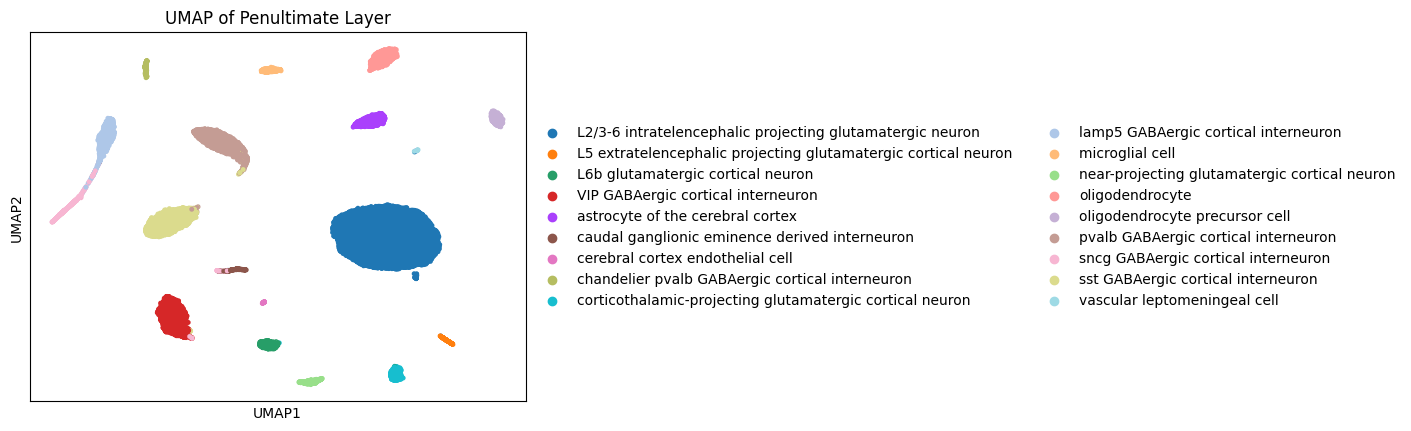

UMAP of penultimate-layer embeddings complete.
1063/1063 [==============================] - 1s 724us/step


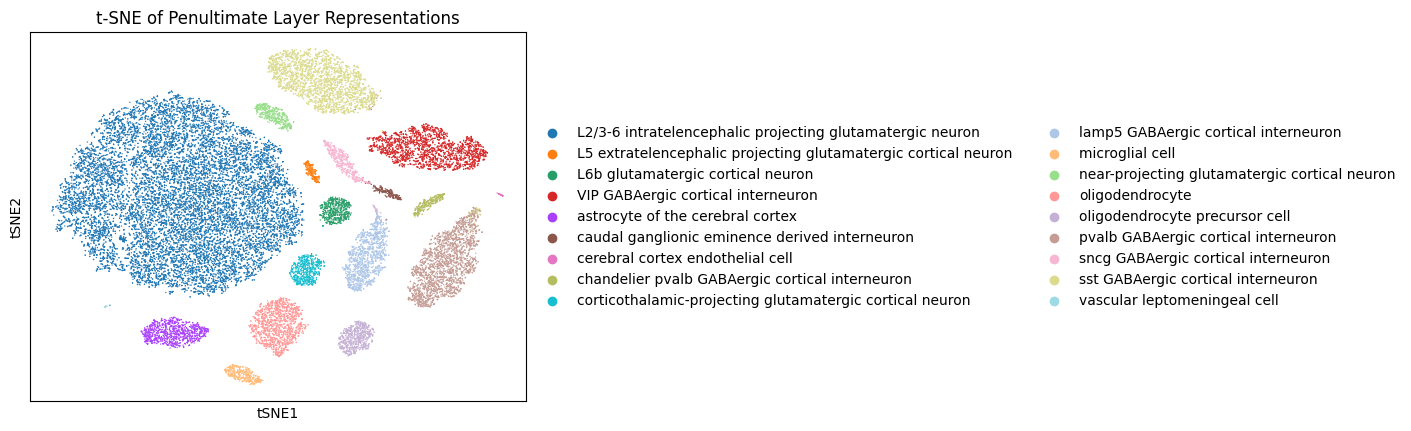

Analysis script complete. You can run optional SHAP or UMAP on new data, etc.


In [20]:
# ------------------------------------------------------------------------------
# ADD-ON: UMAP-tSNE Visualization of the Penultimate Layer (Single Model)
# ------------------------------------------------------------------------------

# 1) Choose one model (e.g., the last in the ensemble)
model_rep = ensemble_models[-1]

# 2) Extract penultimate-layer outputs
penultimate_model = Model(
    inputs=model_rep.input,
    outputs=model_rep.layers[-2].output
)
embeddings_test = penultimate_model.predict(X_test)

# 3) Run UMAP on these embeddings
umap_reducer = umap.UMAP(random_state=42)
umap_emb = umap_reducer.fit_transform(embeddings_test)

# 4) Create an AnnData object for easy plotting with Scanpy
adata_umap = ad.AnnData(X=embeddings_test)
adata_umap.obsm['X_umap'] = umap_emb

# Convert numeric labels -> original cell type strings
test_cell_types = [inv_label_mapping[i] for i in y_test]
adata_umap.obs['cell_type'] = test_cell_types

# 5) Plot with Scanpy's built-in UMAP
sc.pl.umap(
    adata_umap,
    color='cell_type',
    title="UMAP of Penultimate Layer",
    size=50  # adjust marker size if needed
)
print("UMAP of penultimate-layer embeddings complete.")


# t-SNE of the penultimate layer embeddings
model_rep = ensemble_models[-1]
penultimate_model = Model(inputs=model_rep.input, outputs=model_rep.layers[-2].output)
embeddings = penultimate_model.predict(X_test)

tsne_emb = TSNE(n_components=2, random_state=42).fit_transform(embeddings)
adata_tsne = ad.AnnData(X=embeddings)
adata_tsne.obsm['X_tsne'] = tsne_emb
adata_tsne.obs['cell_type'] = [inv_label_mapping[i] for i in y_test]

sc.pl.tsne(
    adata_tsne,
    color='cell_type',
    title="t-SNE of Penultimate Layer Representations"
)

print("Analysis script complete. You can run optional SHAP or UMAP on new data, etc.")


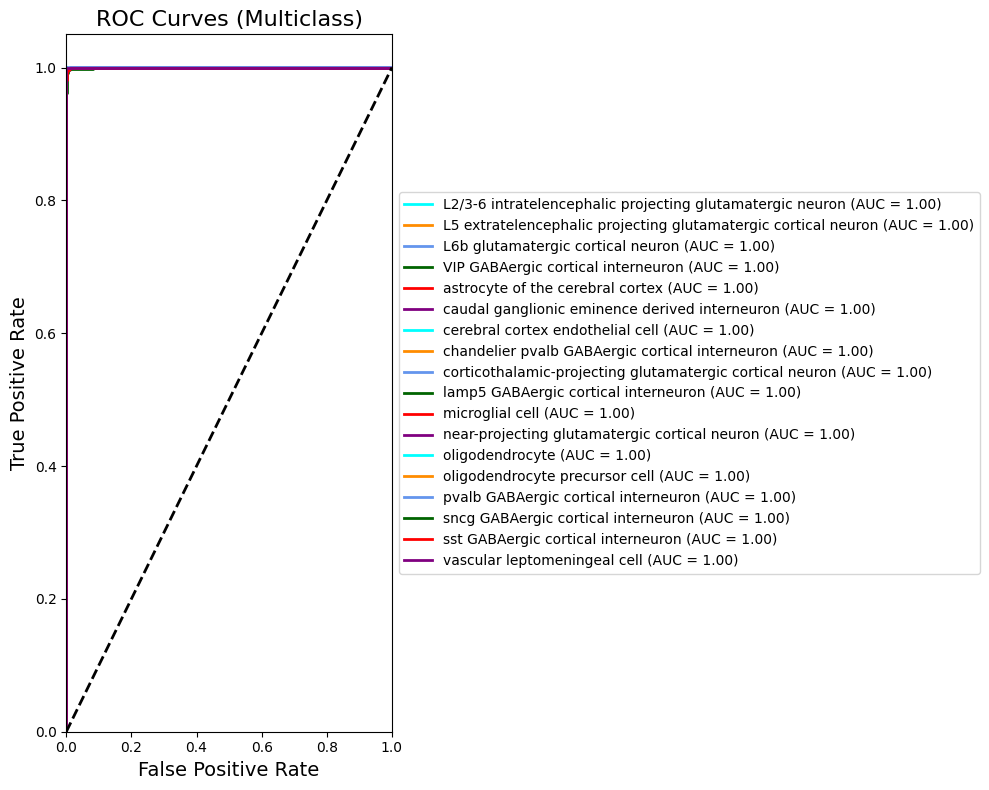

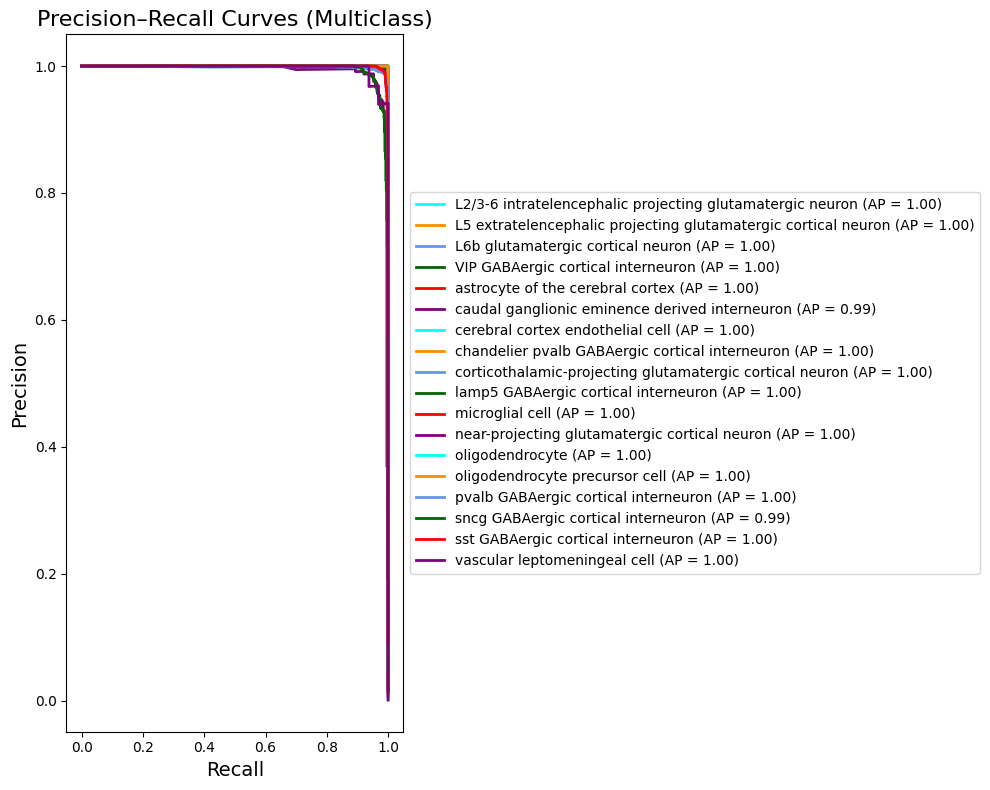

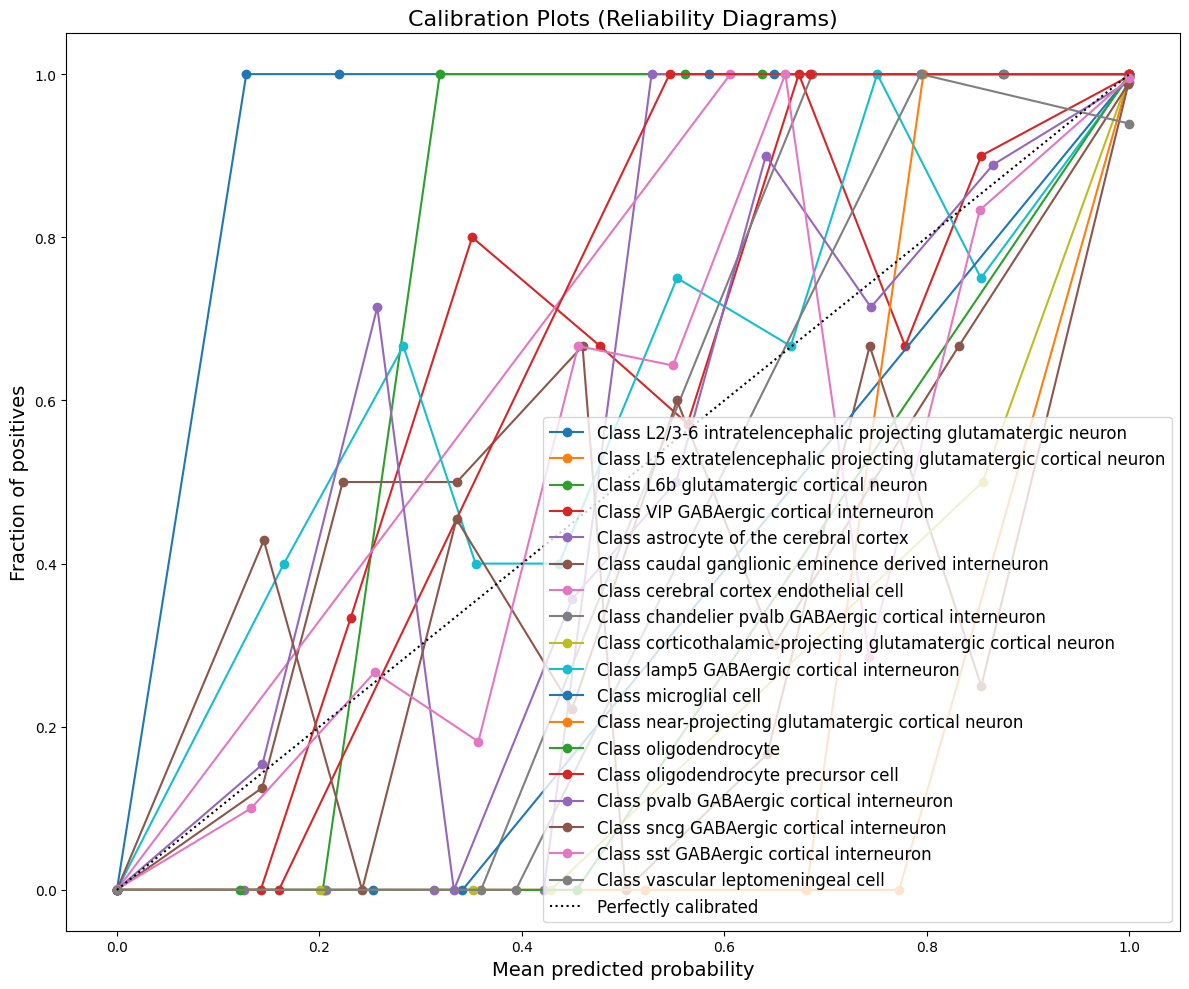

In [19]:
###############################################################################
# Cross-Validation, ROC/PR, Calibration.
###############################################################################
# ROC & PR with the ensemble probability
y_test_bin = label_binarize(y_test, classes=range(num_classes))
fpr, tpr, roc_auc = {}, {}, {}
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'darkgreen', 'red', 'purple'])

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], ensemble_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='{} (AUC = {:.2f})'.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curves (Multiclass)', fontsize=16)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
plt.tight_layout()
plt.show()

# Precision‐Recall
plt.figure(figsize=(10, 8))
for i, color in zip(range(num_classes), colors):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], ensemble_prob[:, i])
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, color=color, lw=2,
             label='{} (AP = {:.2f})'.format(class_names[i], pr_auc))

plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision–Recall Curves (Multiclass)', fontsize=16)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
plt.tight_layout()
plt.show()

# Calibration
plt.figure(figsize=(12, 10))
for i in range(num_classes):
    prob_true, prob_pred = calibration_curve(y_test_bin[:, i], ensemble_prob[:, i], 
                                             n_bins=10, strategy='uniform')
    plt.plot(prob_pred, prob_true, marker='o', linestyle='-', label=f'Class {class_names[i]}')

plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.xlabel("Mean predicted probability", fontsize=14)
plt.ylabel("Fraction of positives", fontsize=14)
plt.title("Calibration Plots (Reliability Diagrams)", fontsize=16)
plt.legend(loc="best", fontsize=12)
plt.tight_layout()
plt.show()

In [21]:
# ------------------------------------------------------------------------------
# SHAP Analysis
# ------------------------------------------------------------------------------
adata = sc.read_h5ad(r"C:/Users/germa/Desktop/DNN-Project/Cortical_DataSet.h5ad")

# 1) I chose a single model for SHAP (in this case the last ensemble model)
model_for_shap = ensemble_models[-1]

# 2) Create a small background set for DeepExplainer
background_size = 100
background = X_train[np.random.choice(X_train.shape[0], background_size, replace=False)]

# 3) Initialize the explainer to compute shap_values on the test set
explainer = shap.DeepExplainer(model_for_shap, background)
shap_values = explainer.shap_values(X_test)  # list if multiclass

# 4) Compute mean absolute SHAP across classes & samples
mean_shap = np.mean(np.abs(np.array(shap_values)), axis=(0, 1))
print("mean_shap shape:", mean_shap.shape)

# Map Ensembl IDs -> gene symbols:

from gprofiler import GProfiler
gp = GProfiler(return_dataframe=True)
ensembl_ids = list(adata.var_names)
mapping_df = gp.convert(organism='hsapiens', query=ensembl_ids)
mapping_dict = dict(zip(mapping_df['incoming'], mapping_df['name']))
gene_names_actual = np.array([mapping_dict.get(g, g) for g in adata.var_names])
min_length = min(len(gene_names_actual), len(mean_shap))
gene_names_actual = gene_names_actual[:min_length]
mean_shap = mean_shap[:min_length]

# 5) DataFrame and plot top 10 features
df_shap = pd.DataFrame({
    'gene_names_actual': np.arange(len(mean_shap)),
    'mean_abs_shap': mean_shap
})
df_shap_sorted = df_shap.sort_values(by='mean_abs_shap', ascending=False)
top10 = df_shap_sorted.head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=top10, x='mean_abs_shap', y='gene', palette='viridis')
plt.title("Top 10 SHAP Feature Importances", fontsize=16)
plt.xlabel("Mean Absolute SHAP Value", fontsize=14)
plt.ylabel("Gene", fontsize=14)
plt.tight_layout()
plt.show()

# 6) Compute abd print accuracy per cell type
y_pred_train = np.argmax(model_for_shap.predict(X_train), axis=1)
y_pred_test  = np.argmax(model_for_shap.predict(X_test), axis=1)

train_cell_types = [inv_label_mapping[i] for i in y_train]
test_cell_types  = [inv_label_mapping[i] for i in y_test]

accuracy_per_type_train = {}
for ct in np.unique(train_cell_types):
    idxs = [i for i, c in enumerate(train_cell_types) if c == ct]
    acc = np.mean(y_pred_train[idxs] == y_train[idxs])
    accuracy_per_type_train[ct] = acc
    print(f"Training Accuracy for {ct}: {acc:.2f}")

accuracy_per_type_test = {}
for ct in np.unique(test_cell_types):
    idxs = [i for i, c in enumerate(test_cell_types) if c == ct]
    acc = np.mean(y_pred_test[idxs] == y_test[idxs])
    accuracy_per_type_test[ct] = acc
    print(f"Test Accuracy for {ct}: {acc:.2f}")

# Combine into a single table
import math
cell_types_unique = sorted(set(train_cell_types + test_cell_types))
accuracy_table = pd.DataFrame({
    "Cell Type": cell_types_unique,
    "Training Accuracy": [accuracy_per_type_train.get(ct, math.nan) for ct in cell_types_unique],
    "Testing Accuracy": [accuracy_per_type_test.get(ct, math.nan) for ct in cell_types_unique]
})
print("\nAccuracy Table:")
print(accuracy_table)

# 7) Save SHAP results
# Save
with open("shap_values.pkl", "wb") as f:
    pickle.dump(shap_values, f)
np.save("mean_shap.npy", mean_shap)
df_shap_sorted.to_csv("shap_gene_importances.csv", index=False)
print("SHAP values, mean_shap, and gene importances saved.")



c:\Users\germa\Coding\envs\tf_env\lib\site-packages\shap\explainers\_deep\deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
c:\Users\germa\Coding\envs\tf_env\lib\site-packages\keras\backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


mean_shap shape: (18,)


ValueError: Could not interpret value `gene` for `y`. An entry with this name does not appear in `data`.

<Figure size 1000x600 with 0 Axes>

In [ ]:
# ------------------------------------------------------------------------------
# LOAD SHAP Analysis
# ------------------------------------------------------------------------------
# Load
with open("shap_values.pkl", "rb") as f:
    shap_values_loaded = pickle.load(f)
mean_shap_loaded = np.load("mean_shap.npy")
df_shap_loaded = pd.read_csv("shap_gene_importances.csv")

print("\nLoaded SHAP results:")
if isinstance(shap_values_loaded, list):
    print("shap_values is a list of length:", len(shap_values_loaded),
          "with shapes:", [arr.shape for arr in shap_values_loaded])
else:
    print("shap_values shape:", shap_values_loaded.shape)
print("mean_shap shape:", mean_shap_loaded.shape)
print("df_shap_loaded shape:", df_shap_loaded.shape)

In [22]:
# ------------------------------------------------------------------------------
# UMAP FEATURE PLOTS
# ------------------------------------------------------------------------------
# UMAP feature plots colored by accuracy
penultimate_model = tf.keras.models.Model(
    inputs=model_for_shap.input, 
    outputs=model_for_shap.layers[-2].output
)

# -- Training set
embeddings_train = penultimate_model.predict(X_train)
umap_train = umap.UMAP(random_state=42).fit_transform(embeddings_train)
adata_train = ad.AnnData(X=embeddings_train)
adata_train.obsm['X_umap'] = umap_train
adata_train.obs['cell_type'] = train_cell_types
adata_train.obs['accuracy'] = [accuracy_per_type_train[ct] for ct in train_cell_types]

sc.pl.umap(
    adata_train,
    color='accuracy',
    cmap='Blues',
    title="UMAP: Training Set Classification Accuracy",
    size=50
)

# -- Test set
embeddings_test = penultimate_model.predict(X_test)
umap_test = umap.UMAP(random_state=42).fit_transform(embeddings_test)
adata_test = ad.AnnData(X=embeddings_test)
adata_test.obsm['X_umap'] = umap_test
adata_test.obs['cell_type'] = test_cell_types
adata_test.obs['accuracy'] = [accuracy_per_type_test[ct] for ct in test_cell_types]

sc.pl.umap(
    adata_test,
    color='accuracy',
    cmap='Blues',
    title="UMAP: Test Set Classification Accuracy",
    size=50
)

print("\nSHAP analysis, accuracy per cell type, and extended UMAP plots completed.")


2480/2480 [==============================] - 2s 758us/step


c:\Users\germa\Coding\envs\tf_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\germa\Coding\envs\tf_env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


NameError: name 'train_cell_types' is not defined

In [ ]:
############################################################################### Section 3 ###############################################################################

In [ ]:
# ------------------------------------------------------------------------------
# Purpose:
# Apply and test the Ensemble to a New Dataset (CorticalMotor)
# ------------------------------------------------------------------------------

# =============================================================================
# APPLY THE MODEL TO NEW DATA (CorticalMotor Dataset)
# =============================================================================

# Load previously saved training variables.
with open('train_variables.pkl', 'rb') as f:
    train_vars = pickle.load(f)
train_genes = train_vars['train_genes']
label_mapping = train_vars['label_mapping']
inv_label_mapping = train_vars['inv_label_mapping']

# ---- Load Ensemble Models ----
n_models = 5  # Adjust as needed.
ensemble_models = [load_model(f'my_trained_model_{i}.h5') for i in range(n_models)]
print("Ensemble models loaded.")

# ---- Load and Preprocess the New Dataset ----
adata_motor = sc.read_h5ad(r"C:/Users/germa/Desktop/DNN-Project/CorticalMotor.h5ad")
print("New Dataset Metadata (first 5 rows):")
print(adata_motor.obs.head())

if adata_motor.raw is not None:
    adata_motor_raw = adata_motor.raw.to_adata()
else:
    adata_motor_raw = adata_motor.copy()

# Apply the same preprocessing as for training.
sc.pp.normalize_total(adata_motor_raw, target_sum=1e4)
sc.pp.log1p(adata_motor_raw)
sc.pp.highly_variable_genes(adata_motor_raw, n_top_genes=3000, subset=True, flavor='seurat')
sc.pp.scale(adata_motor_raw)

# ---- Align New Data to the Training Gene Set ----
# Get the new dataset gene names and expression matrix.
new_genes = np.array(adata_motor_raw.var_names)
X_new_raw = adata_motor_raw.X.toarray() if hasattr(adata_motor_raw.X, "toarray") else adata_motor_raw.X

# Initialize an aligned matrix with zeros (same number of columns as train_genes).
X_new_aligned = np.zeros((X_new_raw.shape[0], len(train_genes)))

# Create a dictionary mapping genes in the new dataset to their column indices.
new_gene_index = {gene: idx for idx, gene in enumerate(new_genes)}

# Fill the aligned matrix with values for genes present in both datasets.
for j, gene in enumerate(train_genes):
    if gene in new_gene_index:
        X_new_aligned[:, j] = X_new_raw[:, new_gene_index[gene]]

X_new = X_new_aligned

# Prepare new dataset labels.
y_new = adata_motor.obs['cell_type'].values
if isinstance(y_new[0], str):
    y_new_numeric = np.array([label_mapping.get(label, -1) for label in y_new])
    if -1 in y_new_numeric:
        print("Some new cell types were not found in the training mapping!")
else:
    y_new_numeric = np.array(y_new)

# ---- Ensemble Prediction on New Data Using a tf.data.Dataset (to save memory) ----
ds_new = tf.data.Dataset.from_tensor_slices(X_new).batch(32)
predictions_list = [model_i.predict(ds_new) for model_i in ensemble_models]
preds = np.mean(predictions_list, axis=0)
y_new_pred_ensemble = np.argmax(preds, axis=1)

accuracy = np.mean(y_new_pred_ensemble == y_new_numeric)
print("New Dataset Accuracy (Ensemble): {:.2f}%".format(accuracy * 100))
print("Classification Report for New Dataset (Ensemble):")
print(classification_report(y_new_numeric, y_new_pred_ensemble))
cm_new = confusion_matrix(y_new_numeric, y_new_pred_ensemble)
print("Confusion Matrix for New Dataset (Ensemble):")
print(cm_new)

Ensemble models loaded.
New Dataset Metadata (first 5 rows):
                                                     Class CrossArea_subclass  \
AACAAGAAGTTTCGAC-LKTX_200720_02_C01-1071413852  inhibitory              Lamp5   
AATTTCCGTGAGCTCC-LKTX_200720_02_C01-1071413852  inhibitory              Lamp5   
ACTGATGCAAATCGGG-LKTX_200720_02_C01-1071413852  inhibitory              Lamp5   
AGCCAGCTCATAGACC-LKTX_200720_02_C01-1071413852  inhibitory               Sncg   
CCTTCAGGTATGAGGC-LKTX_200720_02_C01-1071413852  inhibitory              Lamp5   

                                               CrossArea_cluster  \
AACAAGAAGTTTCGAC-LKTX_200720_02_C01-1071413852           Lamp5_5   
AATTTCCGTGAGCTCC-LKTX_200720_02_C01-1071413852           Lamp5_5   
ACTGATGCAAATCGGG-LKTX_200720_02_C01-1071413852           Lamp5_5   
AGCCAGCTCATAGACC-LKTX_200720_02_C01-1071413852            Sncg_5   
CCTTCAGGTATGAGGC-LKTX_200720_02_C01-1071413852           Lamp5_5   

                                           

3582/3582 [==============================] - 3s 802us/step


c:\Users\germa\Coding\envs\tf_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\germa\Coding\envs\tf_env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


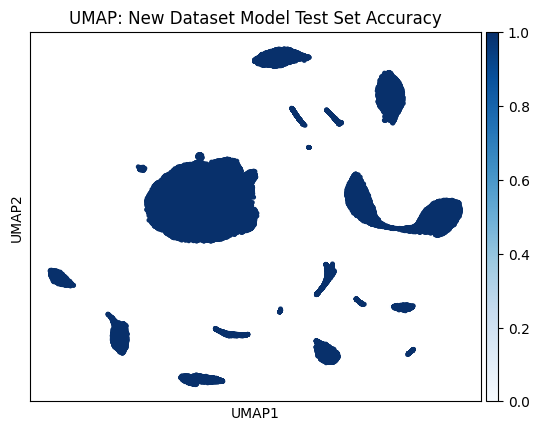

In [8]:

# =============================================================================
#  FEATURE PLOT OF PREDICTION IN NEW DATASET (CorticalMotor Dataset)
# =============================================================================

# Extract penultimate layer features using one representative model.
penultimate_model_new = Model(inputs=ensemble_models[0].input,
                              outputs=ensemble_models[0].layers[-2].output)
embeddings_new = penultimate_model_new.predict(ds_new)

# Compute per-sample accuracy (1 if prediction is correct, 0 otherwise).
accuracy_new = (y_new_pred_ensemble == y_new_numeric).astype(float)

# Compute UMAP embeddings.
umap_model = umap.UMAP(random_state=42)
umap_embeddings_new = umap_model.fit_transform(embeddings_new)

# Create an AnnData object for UMAP plotting.
adata_umap_new = ad.AnnData(X=embeddings_new)
adata_umap_new.obsm['X_umap'] = umap_embeddings_new
adata_umap_new.obs['accuracy'] = accuracy_new
adata_umap_new.obs['cell_type'] = [inv_label_mapping.get(i, "Unknown") for i in y_new_numeric]

# Plot the UMAP feature plot colored by accuracy.
sc.pl.umap(adata_umap_new, color='accuracy', cmap='Blues', 
           title="UMAP: New Dataset Model Test Set Accuracy", size=50)

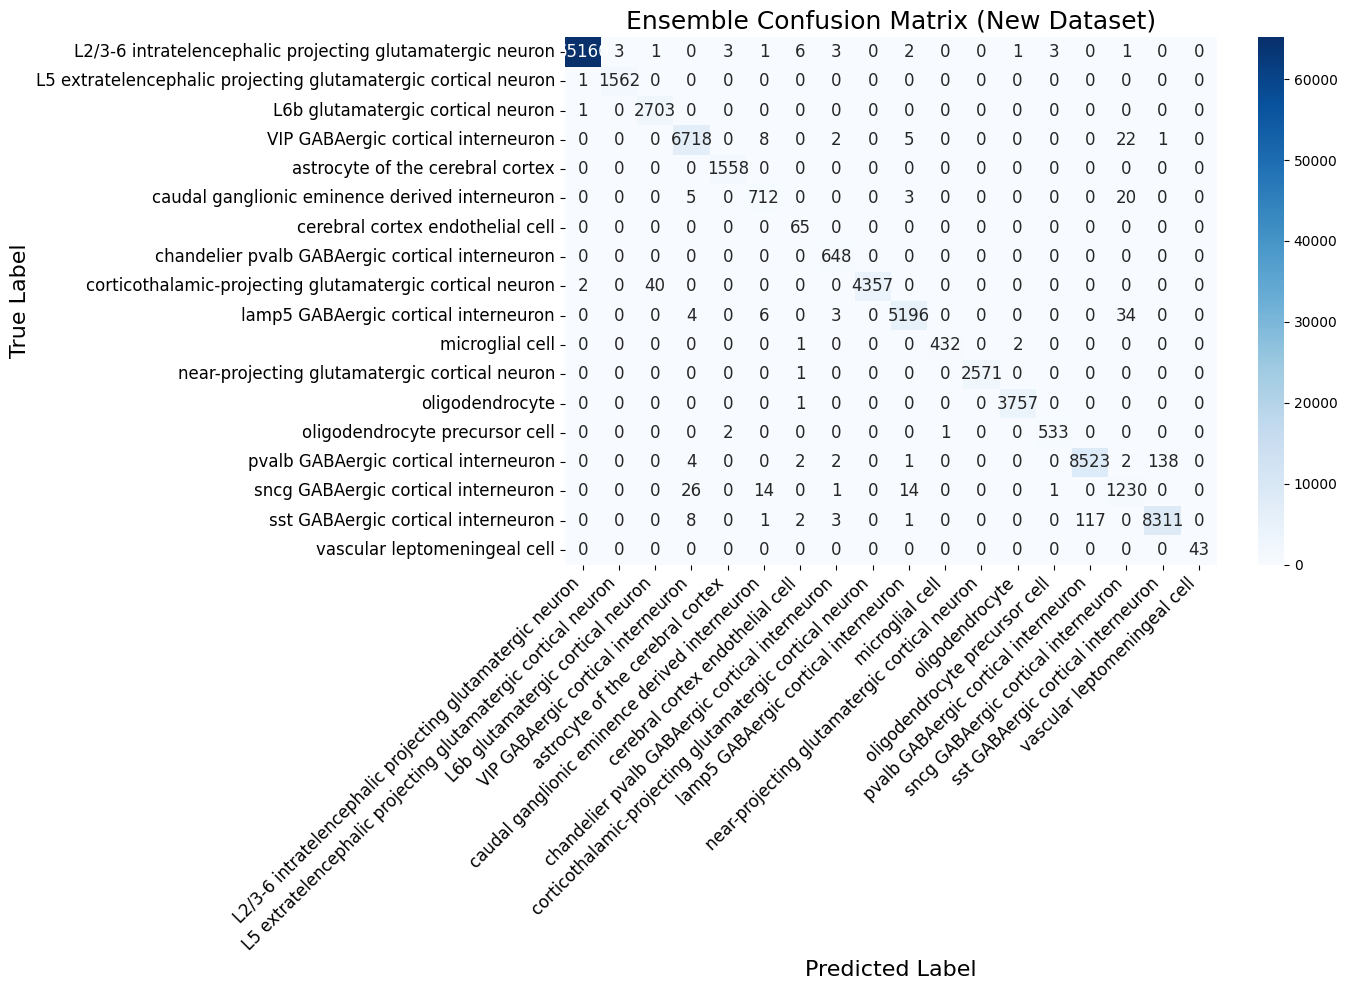

In [17]:

# =============================================================================
#  CONFUSION MATRIX OF PREDICTION IN NEW DATASET (CorticalMotor Dataset)
# =============================================================================

valid_mask = (y_new_numeric != -1)
y_new_valid = y_new_numeric[valid_mask]
y_pred_valid = y_new_pred_ensemble[valid_mask]
unique_new_classes = np.unique(y_new_valid)
class_names_new = [inv_label_mapping[c] for c in unique_new_classes]

cm_new_valid = confusion_matrix(y_new_valid, y_pred_valid, labels=unique_new_classes)

plt.figure(figsize=(14, 10))
sns.heatmap(
    cm_new_valid,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names_new,
    yticklabels=class_names_new,
    annot_kws={"size": 12}
)
plt.title('Ensemble Confusion Matrix (New Dataset)', fontsize=18)
plt.xlabel('Predicted Label', fontsize=16)
plt.ylabel('True Label', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.show()

Unique classes in new dataset (excluding -1): [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
num_classes_new: 18


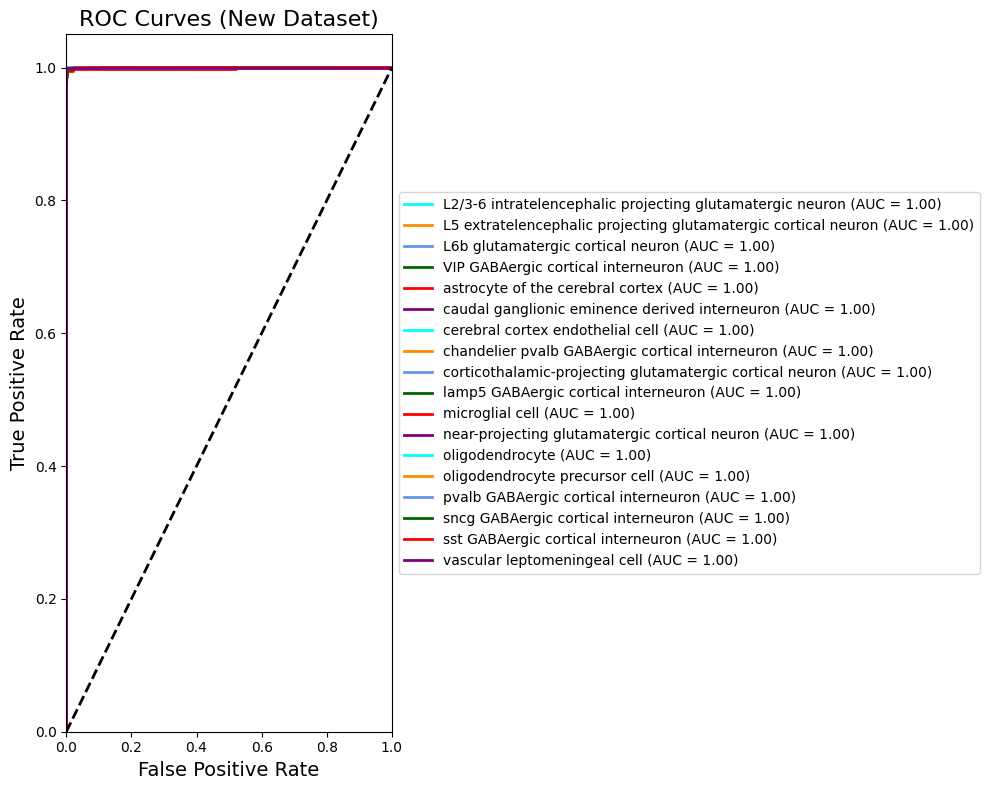

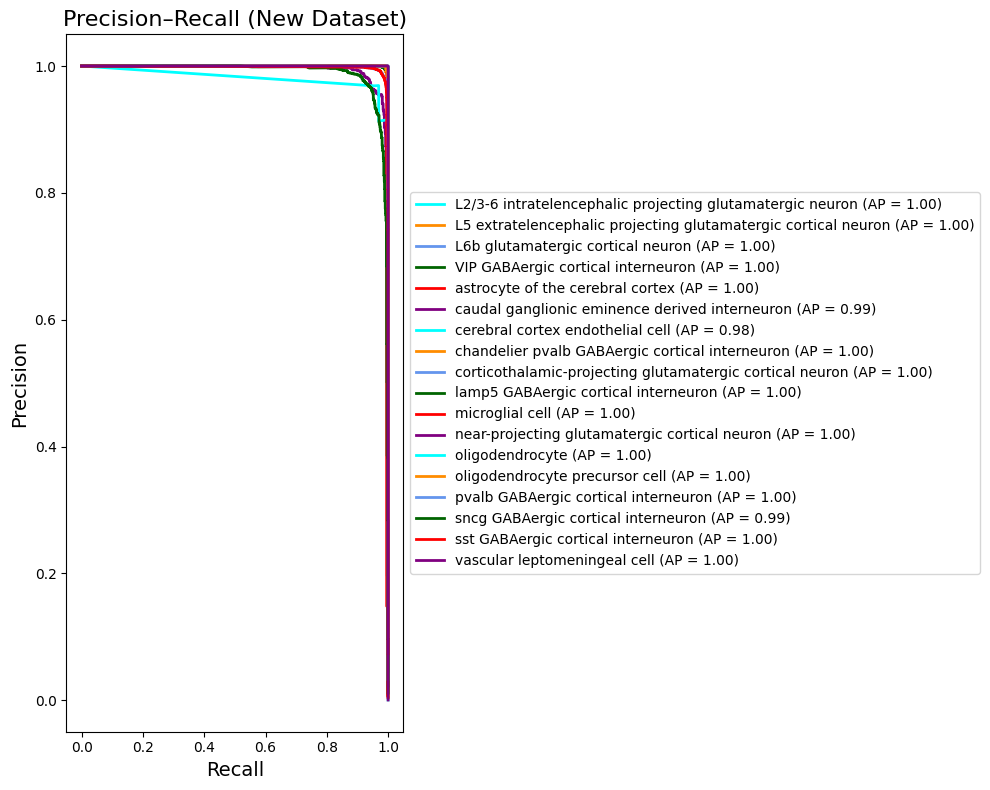

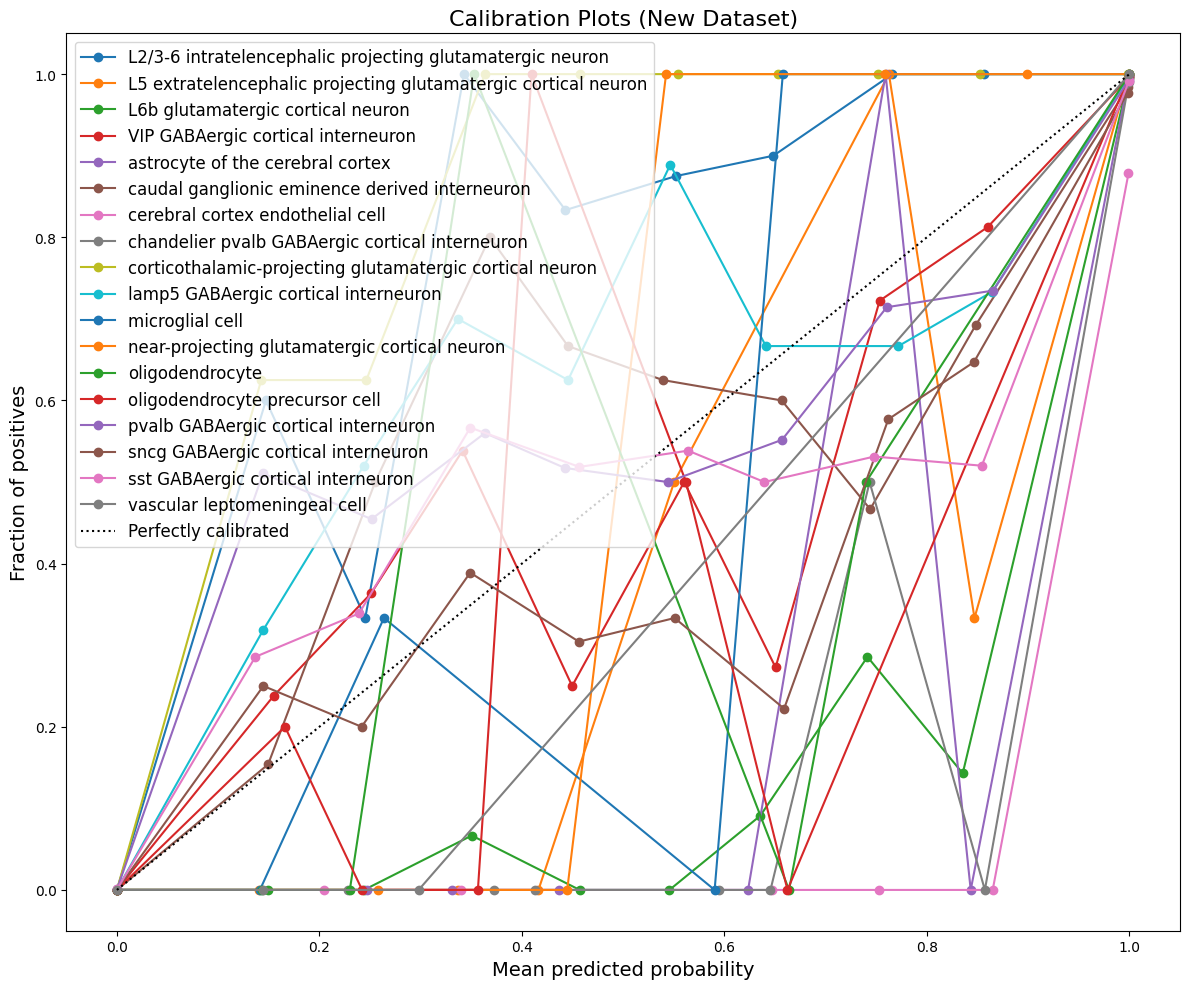

In [18]:

# =============================================================================
#  Cross-Validation, ROC/PR, Calibration IN NEW DATASET (CorticalMotor Dataset)
# =============================================================================
# 1) FILTER OUT ANY -1 LABELS (unknown classes)
valid_mask = (y_new_numeric != -1)
y_new_valid = y_new_numeric[valid_mask]
preds_valid = preds[valid_mask]

unique_new_classes = np.unique(y_new_valid)
print("Unique classes in new dataset (excluding -1):", unique_new_classes)

# Build a list of class names from your old mapping
class_names_new = [inv_label_mapping[c] for c in unique_new_classes]

num_classes_new = len(unique_new_classes)
print("num_classes_new:", num_classes_new)


# 2) MULTICLASS ROC & AUC
from sklearn.preprocessing import label_binarize

# Binarize the new labels. Must specify the classes in ascending order.
y_new_bin = label_binarize(y_new_valid, classes=unique_new_classes)

preds_subset = preds_valid[:, unique_new_classes]

fpr, tpr, roc_auc = {}, {}, {}
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'darkgreen', 'red', 'purple'])

for i, cls_id in enumerate(unique_new_classes):
    # i is index in [0..(num_classes_new-1)]
    # cls_id is the actual numeric label in old mapping
    fpr[i], tpr[i], _ = roc_curve(y_new_bin[:, i], preds_subset[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i, color in zip(range(num_classes_new), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='{} (AUC = {:.2f})'.format(class_names_new[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curves (New Dataset)', fontsize=16)

# Legend outside
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10, ncol=1)
plt.tight_layout()
plt.show()


# 3) PRECISION-RECALL CURVES
plt.figure(figsize=(10, 8))
for i, color in zip(range(num_classes_new), colors):
    precision, recall, _ = precision_recall_curve(y_new_bin[:, i], preds_subset[:, i])
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, color=color, lw=2,
             label='{} (AP = {:.2f})'.format(class_names_new[i], pr_auc))

plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision–Recall (New Dataset)', fontsize=16)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10, ncol=1)
plt.tight_layout()
plt.show()


# 4) CALIBRATION PLOT
plt.figure(figsize=(12, 10))
for i in range(num_classes_new):
    prob_true, prob_pred = calibration_curve(y_new_bin[:, i], preds_subset[:, i],
                                             n_bins=10, strategy='uniform')
    plt.plot(prob_pred, prob_true, marker='o', linestyle='-',
             label='{}'.format(class_names_new[i]))

plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.xlabel("Mean predicted probability", fontsize=14)
plt.ylabel("Fraction of positives", fontsize=14)
plt.title("Calibration Plots (New Dataset)", fontsize=16)
plt.legend(loc="best", fontsize=12)
plt.tight_layout()
plt.show()
